## Midterm TSA
### Group 5

**Member:**
1. Phạm Hoàng Kim Liên

2. Nguyễn Duy Hưng
3. Nguyễn Trọng Hùng
4. Nguyễn Thu Trà
5. Vũ Minh Nhật
6. Cao Ngọc Phương Anh

Let’s consider the dataset of Paris temperature in the course and do the following.
1. Preprocess this data set as in the course to make sure that you have a good
datetime column. Check it by plotting the Paris temperature column. If the plot
looks nicely, that means you did good.
2. The dataset has 33 columns (features). Explain the meaning and values in each
column. For example, what does feature “moonphase” mean? What are its values?
3. Determine numerical features and categorical features.
4. Is it the time series stationary? If not, How many differencing operations needed to
make it stationary? Test the stationary and explain in detail.
5. Our objective is to predict Paris temperature. Split the data into trainset (from
01/10/2023 to 15/09/2024) and testset (the rest) (Out-of-Time).
Apply quickly Prophet model to have an idea of how close we can do for the Paris
temperature predictions. Compute with metrics and explain in
detail.RMSE, R2, MAPE
6. In Paris temperature dataset, you have more (useful) features to determine the
temperature than in NVIDIA dataset.
- a. Feature Engineering: The idea is to train your model to understand exactly
what happens right before the prediction moment (the date time moment).
Let’s call the features of the dataset base features.
    - i. For numerical features, from those features and date time column,
we build derived features like the 7 days-average of solar radiation
right before the date time.
    - ii. For categorical features, try to be creative. You can go with one-hot
encoding or label encoding, etc but actually the meaning of the text
column here is much richer.
    - iii. Do a careful feature selection and explain why.

- b. Model training: Use two following model LightGBM Regressor and Random
Forest on the same trainset and testset from Question 5. Hyperparameter
Tuning as hard as you could (with Optuna) to get the best parameters.
Explain why you use your specific set of parameters to finetune. Compare
the result with that of Question 5.
- c. Model Interpretability: Comment on most important features. Using Shapley
Value or something similar to explain how much each feature contributed to
the prediction.

7. Run the same thing for weekly averaging temperatures and comment.

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [ ]:
! pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import re
import shap
import plotly.express as px
from prophet import Prophet

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/content/paris_temperature.csv')

# Task 1

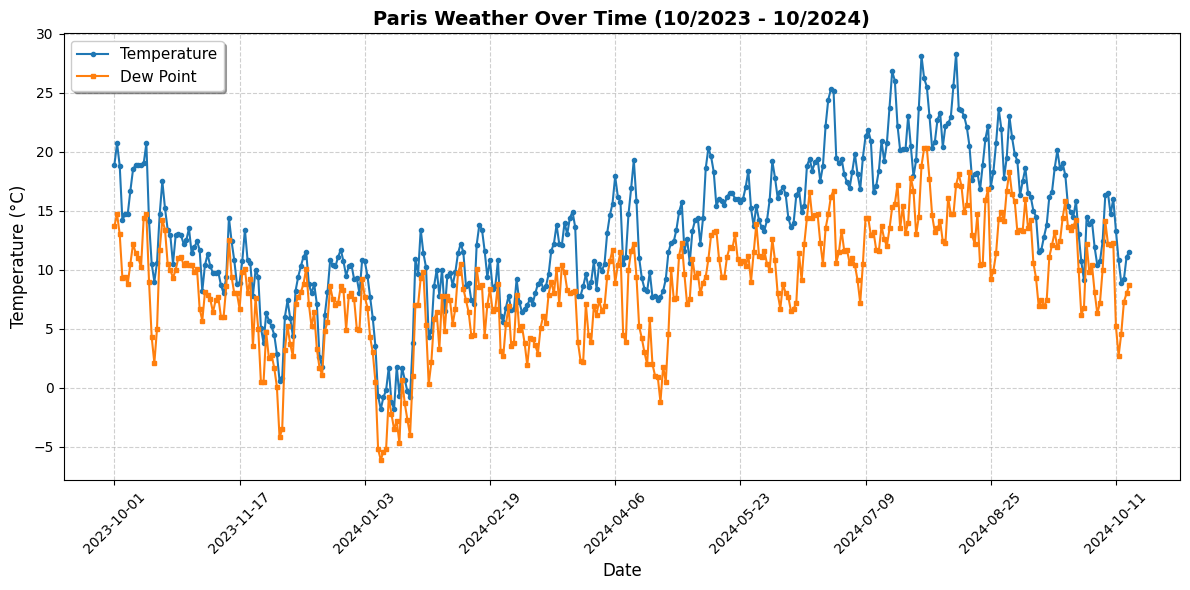

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(df['datetime'], df['temp'], linestyle='-', marker='o', markersize=3, color='#1f77b4', label='Temperature')
plt.plot(df['datetime'], df['dew'], linestyle='-', marker='s', markersize=3, color='#ff7f0e', label='Dew Point')

plt.title('Paris Weather Over Time (10/2023 - 10/2024)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)

num_ticks = 8
selected_dates = df['datetime'][::len(df) // num_ticks]
plt.xticks(selected_dates, rotation=45, fontsize=10)

plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
plt.tight_layout()

plt.show()

# Task 2

Link columns description:

https://docs.google.com/spreadsheets/d/1clEypdr6CIgXhiQ_0xqNOInODWv1G1ThvZAUwva8A38/edit?gid=0#gid=0

In [ ]:
df = pd.read_csv('/content/paris_temperature.csv')

In [ ]:
def calculate_range(column_name):
        min_value = df[column_name].min()
        max_value = df[column_name].max()
        range_value = max_value - min_value

        print(f"Range of the '{column_name}' column:")
        print(f"Minimum value: {min_value}")
        print(f"Maximum value: {max_value}")
        print(f"Range: {min_value} to {max_value}")
        print(f"Difference: {range_value}")

        return min_value, max_value, range_value

In [ ]:
def value_types(column_name):
        value_types = {}
        for column in column_name:
            unique_values = df[column].dropna().unique().tolist()
            value_types[column] = unique_values
            print(f"\nThe '{column}' column has {len(unique_values)} unique values:")
            print(unique_values)

        return value_types

# Task 3

In [ ]:
print("Numerical Features:", df.select_dtypes(include=['int64', 'float64']).columns.tolist())
print("Categorical Features:", df.select_dtypes(include=['object', 'category']).columns.tolist())

Numerical Features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical Features: ['name', 'datetime', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


# Task 4

In [ ]:
# Plotting function
def plotting(title, data, x, y, x_label, y_label):

    fig = px.line(data_frame=data, x=data[x], y=data[y], labels={x: x_label, y: y_label},)

    fig.update_traces(line=dict(color='teal'))  # Set line color for the line

    fig.update_layout(
        template='simple_white',
        font=dict(size=14),
        title=title,
        height=500,
        width=1000,
        title_x=0.5,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show()

In [ ]:
plotting(title='Paris Temperature', data=df, x='datetime', y='temp', x_label='Time', y_label='Temperature')

In [ ]:
# replace the negative values in 'temp' column

corrections = {
    '2024-01-08': 0.0,
    '2024-01-09': 0.0,
    '2024-01-10': 1.0,
    '2024-01-11': 2.0,
    '2024-01-12': 4.0,
    '2024-01-13': 1.0,
    '2024-01-14': 0.0,
    '2024-01-15': 5.0,
    '2024-01-16': 2.0,
    '2024-01-17': 5.0,
    '2024-01-18': 3.0,
    '2024-01-19': 3.0,
    '2024-01-20': 1.0,
    '2024-01-21': 7.0
}

for date, corrected_value in corrections.items():
    df.loc[df['datetime']==date, 'temp'] = corrected_value

In [ ]:
plotting(title='Paris Temperature', data=df, x='datetime', y='temp', x_label='Time', y_label='Temperature')

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['temp'].dropna())

# Print test results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is NOT stationary (fail to reject H₀). Consider differencing or transformation.")

ADF Statistic: -2.7492
p-value: 0.0659
Critical Values:
   1%: -3.4478
   5%: -2.8692
   10%: -2.5709
The time series is NOT stationary (fail to reject H₀). Consider differencing or transformation.


In [ ]:
# Rolling
df['Rolling_3'] = df['temp'].rolling(window=3).mean()
df['Rolling_7'] = df['temp'].rolling(window=7).mean()

fig = px.line(df,
              x='datetime',
              y=['temp', 'Rolling_7', 'Rolling_3'],
              labels={'datetime': 'Time', 'temp': 'Temperature'},
              title='Temperature with 3-day and 7-day Rolling Mean',
              height=550,
              width=1100
              )

fig.update_traces(opacity=0.6, selector=dict(name='Temperature'))
fig.update_traces(line_color='red', selector=dict(name='Rolling_7'))
fig.update_traces(line_color='green', selector=dict(name='Rolling_3'))

fig.show()

In [ ]:
df.drop(columns=['Rolling_3', 'Rolling_7'], inplace=True)

### Differencing
The most common tranformation is differencing
$$ d(t) = y(t) - y(t-1) $$
Where d(t) is the diffence at time t between the series at point y(t) and y(t-1)

In [ ]:
# Differencing

df['temp_diff_1'] = df['temp'].diff()

plotting(title='Temp Diff 1', data=df, x='datetime', y='temp_diff_1', x_label='Time', y_label='Temperature')

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['temp_diff_1'].dropna())

# Print test results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is NOT stationary (fail to reject H₀). Consider differencing or transformation.")


ADF Statistic: -15.0200
p-value: 0.0000
Critical Values:
   1%: -3.4478
   5%: -2.8692
   10%: -2.5709
The time series is stationary (reject H₀).


-> After the first diffencing, the mean is now constant. And our time series data is stationary

In [ ]:
df.drop(columns=['temp_diff_1'], inplace=True)

### Logarithm Transform

In [ ]:
df['preciptype'] = df['preciptype'].fillna('dry')

In [ ]:
df.isnull().sum().sum()

np.int64(14)

In [ ]:
# Logarithm Transform
df['temp_log'] = np.log(df['temp']+1)

plotting(title='Temp Log', data=df.drop('stations', axis=1), x='datetime', y='temp_log', x_label='Time', y_label='Temp Log')

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['temp_log'].dropna())

# Print test results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is NOT stationary (fail to reject H₀). Consider differencing or transformation.")

ADF Statistic: -3.3170
p-value: 0.0141
Critical Values:
   1%: -3.4478
   5%: -2.8692
   10%: -2.5709
The time series is stationary (reject H₀).


In [ ]:
df.drop(columns=['temp_log'], inplace=True)

### Log + Diff

In [ ]:
df['temp_log_diff'] = np.log(df['temp']+1).diff()

plotting(title='Temp Log and Diff', data=df[[col for col in df.columns if col not in ['preciptype_encoded', 'Rolling_3', 'Rolling_7', 'temp_diff_1',
       'temp_log']]], x='datetime', y='temp_log_diff', x_label='Time', y_label='Temp Log Diff')

### ADF test

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['temp_log_diff'].dropna())

# Print test results
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is NOT stationary (fail to reject H₀). Consider differencing or transformation.")


ADF Statistic: -15.7374
p-value: 0.0000
Critical Values:
   1%: -3.4478
   5%: -2.8692
   10%: -2.5709
The time series is stationary (reject H₀).


In [ ]:
df.drop(columns=['temp_log_diff'], inplace=True)

# Task 5

### train test split

In [ ]:
x_prophet_train = df.loc[df['datetime'] <= '2024-09-15',:]
x_prophet_train.shape

(351, 33)

In [ ]:
x_prophet_test = df.loc[df['datetime'] > '2024-09-15',:]
x_prophet_test.shape

(31, 33)

In [ ]:
x_prophet_train = x_prophet_train[['datetime', 'temp']]
x_prophet_train.columns = ['ds', 'y']

In [ ]:
x_prophet_test = x_prophet_test[['datetime', 'temp']]
x_prophet_test.columns = ['ds', 'y']

In [ ]:
x_prophet_train.head(1)

,ds,y
0,2023-10-01,18.9


In [ ]:
y_prophet_train = x_prophet_train['y']
y_prophet_test = x_prophet_test['y']

### Fit model

In [ ]:
x_prophet_train.tail(1)

,ds,y
350,2024-09-15,13.8


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator

class ProphetWrapper(BaseEstimator):
    def __init__(self, seasonality_mode='additive', changepoint_prior_scale=0.05,
                 seasonality_prior_scale=10.0, changepoint_range=0.8, daily_seasonality='auto'):
        self.seasonality_mode = seasonality_mode
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.changepoint_range = changepoint_range
        self.daily_seasonality = daily_seasonality
        self.model = None

    def fit(self, X, y=None):
        df = X.copy()
        df['y'] = y
        from prophet import Prophet
        self.model = Prophet(
            seasonality_mode=self.seasonality_mode,
            changepoint_prior_scale=self.changepoint_prior_scale,
            seasonality_prior_scale=self.seasonality_prior_scale,
            changepoint_range=self.changepoint_range,
            daily_seasonality=self.daily_seasonality
        )
        self.model.fit(df)
        return self

    def predict(self, X):
        forecast = self.model.predict(X)
        return forecast['yhat']

param_distributions = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': np.linspace(0.01, 1.0, 10),
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.9, 1.0],
    'daily_seasonality': [True]
}

prophet_model = ProphetWrapper()
random_search = RandomizedSearchCV(
    estimator=prophet_model,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',  # Scoring metric (use neg_mean_absolute_error for compatibility)
    verbose=1,
    random_state=42
)

random_search.fit(x_prophet_train, y_prophet_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Streaming output truncated to the last 5000 lines.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2d0nemja/zb5tuxrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2d0nemja/8o44guq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7760', 'data', 'file=/tmp/tmp2d0nemja/zb5tuxrb.json', 'init=/tmp/tmp2d0nemja/8o44guq_.json', 'output', 'file=/tmp/tmp2d0nemja/prophet_modelstetquex/prophet_model-20250330145103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to ove

Best parameters: {'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'daily_seasonality': True, 'changepoint_range': 1.0, 'changepoint_prior_scale': np.float64(0.34)}
Best score: -2.904204279517938


### Result

In [ ]:
best_model = random_search.best_estimator_
forecast = best_model.predict(x_prophet_test)

rmse = np.sqrt(mean_squared_error(y_prophet_test, forecast))
print("RMSE:", rmse)

r2 = r2_score(y_prophet_test, forecast)
print("R²:", r2)

mape = np.mean(np.abs((y_prophet_test - forecast) / y_prophet_test)) * 100
print("MAPE:", mape)

RMSE: 2.6935641569502518
R²: 0.2391656492023796
MAPE: nan


RMSE = 2.69 indicates that, on average, the model's predictions deviate from the actual values by approximately 2.69 units

R² = 0.23 indicates that the model explains only 23% of the variance in the target variable, meaning it has limited predictive power. This suggests that the model does not fit the data well and may not perform much better than a simple mean-based prediction.

# Task 6

In [ ]:
# df = pd.read_csv('../Data/paris_temperature.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              382 non-null    object 
 1   datetime          382 non-null    object 
 2   tempmax           382 non-null    float64
 3   tempmin           382 non-null    float64
 4   temp              382 non-null    float64
 5   feelslikemax      382 non-null    float64
 6   feelslikemin      382 non-null    float64
 7   feelslike         382 non-null    float64
 8   dew               382 non-null    float64
 9   humidity          382 non-null    float64
 10  precip            382 non-null    float64
 11  precipprob        382 non-null    float64
 12  precipcover       382 non-null    float64
 13  preciptype        382 non-null    object 
 14  snow              382 non-null    float64
 15  snowdepth         382 non-null    float64
 16  windgust          382 non-null    float64
 1

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

name                 0
datetime             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
preciptype           0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
uvindex              0
severerisk           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            14
dtype: int64


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
object_columns = df.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['name', 'datetime', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [ ]:
df['preciptype'].value_counts()

,count
preciptype,
rain,301
dry,74
"rain,snow",6
"rain,freezingrain,snow",1


In [ ]:
df['icon'].value_counts()

,count
icon,
rain,269
partly-cloudy-day,84
cloudy,20
snow,5
clear-day,4


In [ ]:
df['conditions'].value_counts()

,count
conditions,
"Rain, Partially cloudy",136
"Rain, Overcast",133
Partially cloudy,84
Overcast,20
Clear,4
"Snow, Rain, Overcast",3
"Snow, Rain, Partially cloudy",1
"Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy",1


In [ ]:
df['description'].value_counts()

,count
description,
Partly cloudy throughout the day.,81
Cloudy skies throughout the day with rain.,49
Cloudy skies throughout the day with a chance of rain throughout the day.,42
Partly cloudy throughout the day with rain.,39
Cloudy skies throughout the day.,20
Partly cloudy throughout the day with morning rain.,17
Partly cloudy throughout the day with early morning rain.,16
Partly cloudy throughout the day with late afternoon rain.,15
Partly cloudy throughout the day with rain clearing later.,14


In [ ]:
df['stations'].value_counts()

,count
stations,
"07149099999,07156099999,07146099999,07157099999,C1292,07147099999,07150099999",247
"07149099999,07156099999,07146099999,07145099999,07157099999,C1292,07147099999,07150099999",36
"07149099999,07156099999,07146099999,LFPV,07157099999,C1292,07147099999,LFPO,07150099999,LFPB",18
"07149099999,07156099999,07146099999,07157099999,C1292,07147099999,07150099999,D3623",12
"LFPV,C1292,LFPO,LFPB",10
"07149099999,07156099999,07146099999,07153099999,07157099999,C1292,07147099999,07150099999",6
"07149099999,07156099999,07146099999,LFPV,07145099999,07153099999,07157099999,C1292,07147099999,LFPO,07150099999,LFPB",6
"07149099999,07156099999,07146099999,07157099999,07147099999,C1292,07150099999,D3623",5
"07149099999,07156099999,07146099999,07145099999,07157099999,C1292,07147099999,07150099999,D3623",3


## Preprocessing

In [ ]:
df = df.drop(columns=['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'name', 'solarenergy'])

### Handle Description by using keyword or tfdif

In [ ]:
'''
tfidf = TfidfVectorizer(ngram_range=(2, 3))
tfidf.fit(df['description'].fillna(''))
description_encoded = tfidf.transform(df['description'].fillna('')).toarray()
description_encoded_df = pd.DataFrame(description_encoded, columns=tfidf.get_feature_names_out())
df = pd.concat([df.reset_index(drop=True), description_encoded_df.reset_index(drop=True)], axis=1)
df = df.drop(columns=['description'], axis=1)
'''

"\ntfidf = TfidfVectorizer(ngram_range=(2, 3))\ntfidf.fit(df['description'].fillna(''))\ndescription_encoded = tfidf.transform(df['description'].fillna('')).toarray()\ndescription_encoded_df = pd.DataFrame(description_encoded, columns=tfidf.get_feature_names_out())\ndf = pd.concat([df.reset_index(drop=True), description_encoded_df.reset_index(drop=True)], axis=1)\ndf = df.drop(columns=['description'], axis=1)\n"

In [ ]:
# Description
keywords = [
    'Partly cloudy throughout the day',
    'morning rain',
    'afternoon rain',
    'clearing later',
    'Cloudy skies throughout the day',
    'chance of rain',
    'late afternoon rain',
    'Becoming cloudy in the afternoon'
]


for keyword in keywords:
    df[keyword] = df['description'].apply(lambda x: 1 if keyword in x else 0)

df = df.drop(columns=['description'])

## Fill NaN

Fill NaN for station column = those that recorded similar temperatures.

In [ ]:
# Điền NaN = station đo được nhiệt độ giống nhất

# Bước 1: Tính nhiệt độ trung bình của các dòng có 'stations' là NaN
nan_temp_mean = df[df['stations'].isnull()]['temp'].mean()

# Bước 2: Tính nhiệt độ trung bình cho mỗi station (chỉ với các dòng không NaN)
station_temp_means = df[df['stations'].notnull()].groupby('stations')['temp'].mean()

# Bước 3: Tìm station có nhiệt độ trung bình gần nhất với nan_temp_mean
# Sử dụng hiệu số tuyệt đối và tìm chỉ số (tên station) với hiệu số nhỏ nhất
closest_station = (station_temp_means - nan_temp_mean).abs().idxmin()
df.loc[df['stations'].isnull(), 'stations'] = closest_station

Fill NaN for preciptype with "Dry" because the NaN days were usually dry.

In [ ]:
df['preciptype'] = df['preciptype'].fillna('dry')

## Handle Objective columns

Remove the columns sunrise and sunset, replacing them with sun_duration, which represents the duration of sunlight. Create dummy variables for preciptype.

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])

# Sắp xếp theo cột datetime
df = df.sort_values(by='datetime')

# Tạo cột sun_duration (thời gian mặt trời lặn - mọc, tính bằng giờ)
df['sun_duration'] = (df['sunset'] - df['sunrise']).dt.total_seconds() / 3600  # Chuyển thành giờ

# Loại bỏ cột sunrise và sunset
df = df.drop(columns=['sunrise', 'sunset'])

In [ ]:
df['preciptype'] = df['preciptype'].apply(
    lambda x: 'snow' if 'snow' in x
              else ('rain' if 'rain' in x
                    else 'dry')
)
df['preciptype'].value_counts()

,count
preciptype,
rain,301
dry,74
snow,7


In [ ]:
df = pd.get_dummies(df, columns=['preciptype'], drop_first=False)
df = df.sort_values(by='datetime')

Classify stations into clusters on the training set (based on temperature) and then transform with the test set.

In [ ]:
# Tạo bản sao khi chia train/test để tránh SettingWithCopyWarning
split_date = df['datetime'].max() - pd.Timedelta(days=15)

df_train = df[df['datetime'] < split_date].copy()
df_test = df[df['datetime'] >= split_date].copy()

# Tính trung bình temp theo station
df_train.loc[:, 'station_avg_temp'] = df_train.groupby('stations')['temp'].transform('mean')

# Chuẩn hoá
scaler = StandardScaler()
station_avg_temp_scaled = scaler.fit_transform(df_train[['station_avg_temp']])

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_train.loc[:, 'station_cluster'] = kmeans.fit_predict(station_avg_temp_scaled)

# Áp dụng cho tập test
df_test.loc[:, 'station_avg_temp'] = df_test.groupby('stations')['temp'].transform('mean')
df_test.loc[:, 'station_avg_temp'] = df_test['station_avg_temp'].fillna(df_train['station_avg_temp'].mean())

station_avg_temp_scaled_test = scaler.transform(df_test[['station_avg_temp']])
df_test.loc[:, 'station_cluster'] = kmeans.predict(station_avg_temp_scaled_test)

# Gộp lại
df_merged = pd.concat([df_train, df_test], ignore_index=True)

# Bỏ cột không cần thiết
df_merged = df_merged.drop(columns=['stations', 'station_avg_temp'])

df_merged.head()


,datetime,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,moonphase,conditions,icon,Partly cloudy throughout the day,morning rain,afternoon rain,clearing later,Cloudy skies throughout the day,chance of rain,late afternoon rain,Becoming cloudy in the afternoon,sun_duration,preciptype_dry,preciptype_rain,preciptype_snow,station_cluster
0,2023-10-01,18.9,13.7,74.3,0.144,100.0,4.17,0.0,0.0,25.0,11.3,170.2,1023.7,46.5,18.6,39.8,3,10,0.57,"Rain, Partially cloudy",rain,1,1,0,0,0,0,0,0,11.681389,False,True,False,0
1,2023-10-02,20.7,14.7,71.0,0.000,0.0,0.00,0.0,0.0,26.3,12.0,173.7,1018.8,48.6,16.8,51.3,4,10,0.60,Partially cloudy,partly-cloudy-day,1,0,0,0,0,0,0,0,11.622222,True,False,False,0
2,2023-10-03,18.8,13.0,69.9,0.386,100.0,12.50,0.0,0.0,51.6,22.8,277.2,1020.5,71.8,22.1,54.5,4,10,0.63,"Rain, Partially cloudy",rain,1,0,0,0,0,0,0,0,11.563056,False,True,False,0
3,2023-10-04,14.2,9.3,73.2,0.006,100.0,4.17,0.0,0.0,23.6,12.3,260.9,1029.8,62.0,22.4,58.9,4,10,0.66,"Rain, Partially cloudy",rain,1,1,0,0,0,0,0,0,11.503611,False,True,False,0
4,2023-10-05,14.7,9.4,72.1,0.014,100.0,4.17,0.0,0.0,16.3,6.8,238.3,1027.3,82.3,21.3,41.7,3,10,0.70,"Rain, Partially cloudy",rain,1,1,0,0,0,0,0,0,11.444722,False,True,False,0


In [ ]:
df = df_merged

Create columns temp_max, temp_min, and temp_mean for each condition.

For example, when it rains, calculate the highest, lowest, and average temperatures.

Use LabelEncoder for the conditions column on the training set and transform it for the test set.

In [ ]:
split_date = df['datetime'].max() - pd.Timedelta(days=15)
df_train = df[df['datetime'] < split_date]

# Tính thống kê cho cột 'temp' theo từng 'conditions'
df_temp_stats = df_train.groupby('conditions')['temp'].agg(['min', 'max', 'mean']).reset_index()
df_temp_stats.columns = ['conditions', 'temp_min', 'temp_max', 'temp_mean']
df_temp_stats

,conditions,temp_min,temp_max,temp_mean
0,Clear,2.0,28.3,15.900000
1,Overcast,0.0,23.6,9.575000
2,Partially cloudy,0.6,28.1,15.553846
3,"Rain, Overcast",3.5,23.5,12.562791
4,"Rain, Partially cloudy",2.6,26.2,13.761194
5,"Snow, Rain, Freezing Drizzle/Freezing Rain, Pa...",3.0,3.0,3.000000
6,"Snow, Rain, Overcast",0.0,5.0,1.666667
7,"Snow, Rain, Partially cloudy",1.0,1.0,1.000000


In [ ]:
df = df.merge(df_temp_stats, on='conditions', how='left')
# Tạo đối tượng encoder
le = LabelEncoder()
# Áp dụng encoding
df['conditions_encoded'] = le.fit_transform(df['conditions'])
df = df.drop(columns=['icon', 'conditions'])

### 'winddir' Feature Engineering

In [ ]:
df['winddir_sin'] = np.sin(np.radians(df['winddir']))
df['winddir_cos'] = np.cos(np.radians(df['winddir']))
df.drop(columns=['winddir'], inplace=True)

In [ ]:
df.info()
df1 = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   datetime                          382 non-null    datetime64[ns]
 1   temp                              382 non-null    float64       
 2   dew                               382 non-null    float64       
 3   humidity                          382 non-null    float64       
 4   precip                            382 non-null    float64       
 5   precipprob                        382 non-null    float64       
 6   precipcover                       382 non-null    float64       
 7   snow                              382 non-null    float64       
 8   snowdepth                         382 non-null    float64       
 9   windgust                          382 non-null    float64       
 10  windspeed                         382 non-null    

## Creare lag features

Create lag 1 and rolling window features for 3 and 7 days (excluding the current day).

In [ ]:
columns_to_lag_roll = [col for col in df.columns if col not in ['datetime', 'station']]

In [ ]:
def create_lagged_and_rolling_features(df, columns, lags=[1], rolling_windows=[3, 7]):
    df = df.copy()
    new_features = []

    for col in columns:
        # Tạo lagged features cho cột được chỉ định
        for lag in lags:
            new_features.append(pd.DataFrame({f'{col}_lag{lag}': df[col].shift(lag)}))

        # Tạo rolling window features cho cột đó
        for window in rolling_windows:
            roll_df = pd.DataFrame()  # tạo một DataFrame tạm thời
            roll_df[f'{col}_roll{window}_mean'] = df[col].rolling(window=window, closed='left').mean()
            roll_df[f'{col}_roll{window}_max'] = df[col].rolling(window=window, closed='left').max()
            roll_df[f'{col}_roll{window}_min'] = df[col].rolling(window=window, closed='left').min()
            roll_df[f'{col}_roll{window}_std'] = df[col].rolling(window=window, closed='left').std()
            new_features.append(roll_df)

    # Nối tất cả các DataFrame mới vào DataFrame gốc
    df = pd.concat([df] + new_features, axis=1)

    # Nếu cột được dùng để tạo lag thì loại bỏ cột gốc đó
    if lags:
        cols_to_drop = [col for col in columns if col != 'temp']
        df = df.drop(columns=cols_to_drop, errors='ignore')

    # Loại bỏ các hàng có giá trị NaN do các phép tính shift và rolling tạo ra
    df = df.dropna()
    return df

In [ ]:
df = create_lagged_and_rolling_features(df=df, columns=columns_to_lag_roll)

In [ ]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

## Model

### RF with Optuna
- n_estimators (Số lượng cây)
- max_depth (Độ sâu tối đa của cây)
- min_samples_split (Số lượng mẫu tối thiểu để chia một nút)
- min_samples_leaf (Số lượng mẫu tối thiểu trong một lá)
- bootstrap (Lấy mẫu có hoàn lại hay không)

In [ ]:
train_df = df.iloc[:-15]
test_df = df.iloc[-15:]
features = df.columns.difference(['datetime', 'temp'])
X_train = train_df[features]
y_train = train_df['temp']
X_test = test_df[features]
y_test = test_df['temp']

# ------------------------------
def train_random_forest(X_train, y_train, X_test, y_test):
    """Huấn luyện mô hình Random Forest sử dụng Optuna để tối ưu hyperparameters."""

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "random_state": 42,
        }

        # Chia dữ liệu train thành 80% train fold và 20% validation fold
        split_index = int(len(X_train) * 0.8)
        X_train_fold, X_val_fold = X_train.iloc[:split_index], X_train.iloc[split_index:]
        y_train_fold, y_val_fold = y_train.iloc[:split_index], y_train.iloc[split_index:]

        model = RandomForestRegressor(**params, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        return rmse

    # Tạo study và tối ưu hyperparameters
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params["random_state"] = 42  # Đảm bảo tính tái lập

    # Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu train
    final_model = RandomForestRegressor(**best_params, n_jobs=-1)
    final_model.fit(X_train, y_train)
    predictions = final_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    print(f"Best Parameters: {best_params}")
    print(f"Test RMSE: {rmse}")
    print(f"Test R-squared: {r2}")
    print(f"Test MSE: {mse}")

    return final_model, rmse, r2, mse

final_model, rmse, r2, mse = train_random_forest(X_train, y_train, X_test, y_test)
# Dự đoán trên tập test và thêm cột dự đoán vào test_df:
test_df = test_df.copy()  # Để tránh cảnh báo SettingWithCopyWarning
test_df['predicted_temp'] = final_model.predict(X_test)

# In kết quả:
print(test_df[['datetime', 'temp', 'predicted_temp']])

[I 2025-03-30 14:53:52,439] A new study created in memory with name: no-name-392f44a8-6603-4465-aacd-fea7e1558d1e
[I 2025-03-30 14:53:53,558] Trial 0 finished with value: 3.231285143169853 and parameters: {'n_estimators': 441, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.231285143169853.
[I 2025-03-30 14:53:54,994] Trial 1 finished with value: 3.1435923791741924 and parameters: {'n_estimators': 612, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 3.1435923791741924.
[I 2025-03-30 14:53:56,733] Trial 2 finished with value: 4.0588950412164815 and parameters: {'n_estimators': 785, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 3.1435923791741924.
[I 2025-03-30 14:53:58,936] Trial 3 finished with value: 3.8679366946173652 and parameters: {'n_estimators': 757, 'max_depth': 19, 'min

Best Parameters: {'n_estimators': 402, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
Test RMSE: 1.5188388917480096
Test R-squared: 0.6087572510707925
Test MSE: 2.306871579086322
      datetime  temp  predicted_temp
367 2024-10-02  14.1       13.151493
368 2024-10-03  11.9       13.030348
369 2024-10-04  10.4       12.998507
370 2024-10-05  10.7       11.150995
371 2024-10-06  12.4       12.052239
372 2024-10-07  16.3       13.451741
373 2024-10-08  16.5       16.077363
374 2024-10-09  14.7       15.909204
375 2024-10-10  16.0       15.312189
376 2024-10-11  13.3       15.744527
377 2024-10-12  10.8       11.634328
378 2024-10-13   8.9       10.631841
379 2024-10-14   9.2        9.361940
380 2024-10-15  11.1        8.801244
381 2024-10-16  11.5       11.124378


### SHAP for RF

**temp_lag1** plays the most important role in the daily prediction model, completely dominating other features.

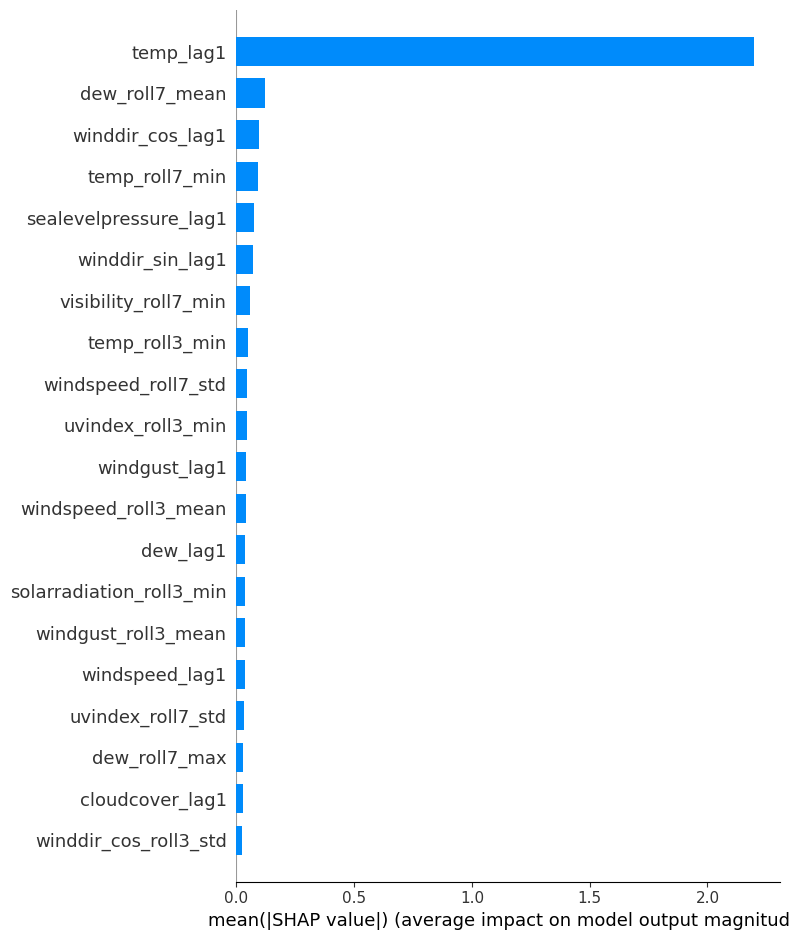

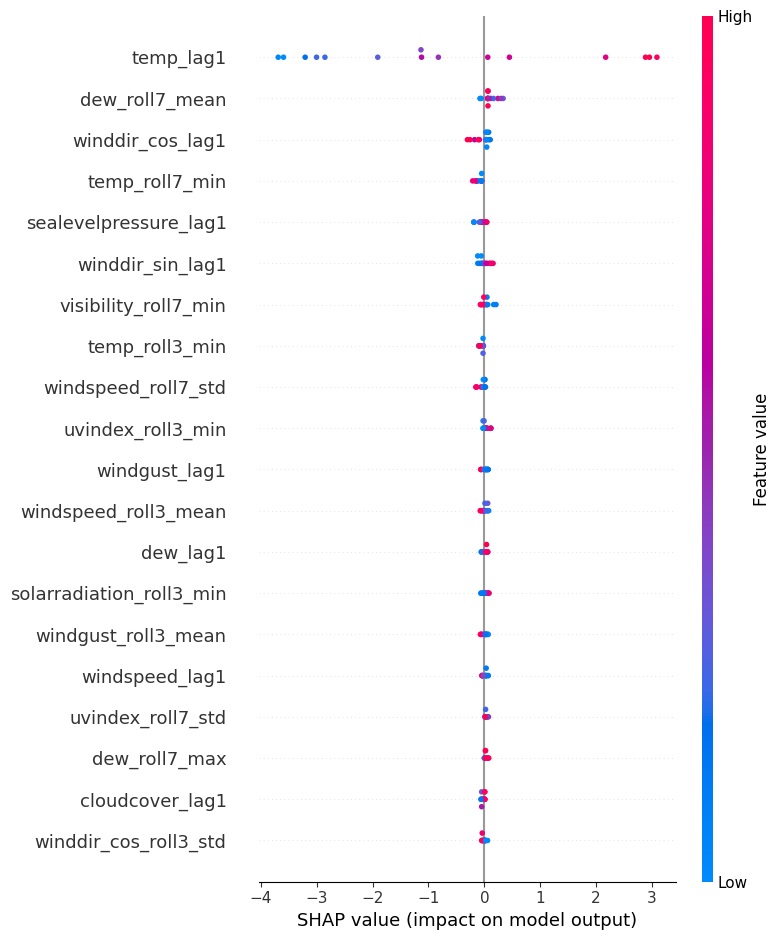

In [ ]:
explainer_lgb = shap.TreeExplainer(final_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Summary Plot (toàn bộ tập test)
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar")  # Mức độ quan trọng tổng thể
plt.show()
shap.summary_plot(shap_values_lgb, X_test)  # Dạng beeswarm (chi tiết hơn)
plt.show()
# Force Plot (cho một mẫu dữ liệu cụ thể)
sample_index = 0  # Chọn một mẫu bất kỳ từ tập test (ví dụ: mẫu đầu tiên)
shap.force_plot(explainer_lgb.expected_value, shap_values_lgb[sample_index, :], X_test.iloc[sample_index, :])
plt.show()

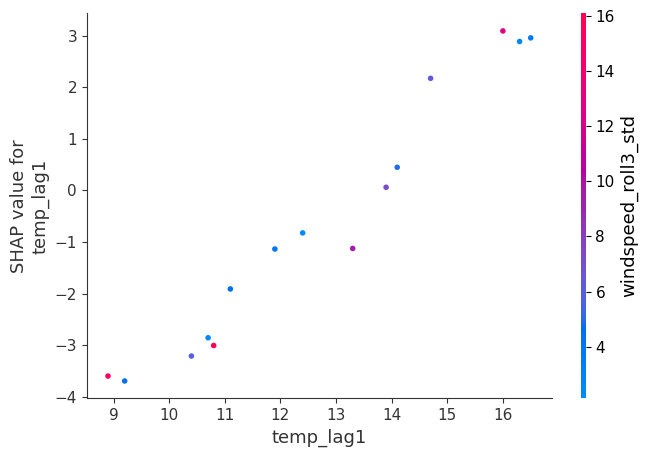

In [ ]:
# Dependence Plot (mối quan hệ giữa một feature và SHAP value của nó)
shap.dependence_plot("temp_lag1", shap_values_lgb, X_test)
plt.show()

Best trial: FrozenTrial(number=22, state=1, values=[2.1399635490650466], datetime_start=datetime.datetime(2025, 3, 28, 17, 59, 22, 879381), datetime_complete=datetime.datetime(2025, 3, 28, 17, 59, 36, 689352), params={'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=50), 'max_depth': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=22, value=None)
Best MSE: 2.1399635490650466
Best params: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}
Mean Squared Error (best model): 2.1399635490650466
Root Mean Squared Error (best model): 1.4628614251066459

###  LightGBM with Optuna
- num_leaves (Số lượng lá)
- max_depth (Độ sâu tối đa của cây)
- learning_rate (Tốc độ học)
- n_estimators (Số lượng cây trong mô hình)
- min_child_samples (Số lượng mẫu nhỏ nhất để chia nhánh)
- subsample (Tỷ lệ dữ liệu lấy mẫu cho mỗi cây)
- colsample_bytree (Tỷ lệ cột được lấy mẫu cho mỗi cây)
- reg_alpha (L1 Regularization)
- reg_lambda (L2 Regularization)
- verbose (-1 để tắt cảnh báo)


In [ ]:
df['preciptype_dry_lag1'] = df['preciptype_dry_lag1'].astype(int)
df['preciptype_rain_lag1'] = df['preciptype_rain_lag1'].astype(int)
df['preciptype_snow_lag1'] = df['preciptype_snow_lag1'].astype(int)

In [ ]:
# Chuẩn bị dữ liệu
train_df = df.iloc[:-15]
test_df = df.iloc[-15:]

features = df.columns.difference(['datetime', 'temp'])
X_train = train_df[features]
y_train = train_df['temp']
X_test = test_df[features]
y_test = test_df['temp']

def train_lgbm(X_train, y_train, X_test, y_test):
    """Trains a LightGBM model with Optuna (no categorical features)."""

    def objective(trial):
        params = {
            "objective": "regression", "metric": "rmse", "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 100),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "verbosity": -1,
        }

        split_index = int(len(X_train) * 0.8)
        X_train_fold, X_val_fold = X_train.iloc[:split_index], X_train.iloc[split_index:]
        y_train_fold, y_val_fold = y_train.iloc[:split_index], y_train.iloc[split_index:]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[lgb.early_stopping(50, verbose=False)],
        )
        preds = model.predict(X_val_fold)
        # Use root_mean_squared_error directly
        rmse = root_mean_squared_error(y_val_fold, preds)
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update({"objective": "regression", "metric": "rmse", "random_state": 42, "verbosity": -1})

    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)
    predictions = final_model.predict(X_test)
    # Use root_mean_squared_error for the final evaluation too
    rmse = root_mean_squared_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    print(f"Best Parameters: {best_params}")
    print(f"Test RMSE: {rmse}")
    print(f"Test MSE: {mse}")
    return final_model, rmse, mse

final_model, rmse, mse = train_lgbm(X_train, y_train, X_test, y_test)
# Dự đoán trên tập test và thêm cột dự đoán vào test_df:
test_df = test_df.copy()  # Để tránh cảnh báo SettingWithCopyWarning
test_df['predicted_temp'] = final_model.predict(X_test)

# In kết quả:
print(test_df[['datetime', 'temp', 'predicted_temp']])


[I 2025-03-30 15:05:51,661] A new study created in memory with name: no-name-7d2270e8-d026-4986-b72c-b3fb5ed316b8
[I 2025-03-30 15:05:52,198] Trial 0 finished with value: 3.1360693397066743 and parameters: {'n_estimators': 305, 'learning_rate': 0.00994694723710911, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7719485936752392, 'colsample_bytree': 0.8232293710377306, 'reg_alpha': 0.3693092381403462, 'reg_lambda': 0.0016344956508640488}. Best is trial 0 with value: 3.1360693397066743.
[I 2025-03-30 15:05:52,435] Trial 1 finished with value: 2.6268192175484066 and parameters: {'n_estimators': 807, 'learning_rate': 0.0909727991372849, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.646651473120238, 'colsample_bytree': 0.6201332128174146, 'reg_alpha': 0.14266559603911716, 'reg_lambda': 0.3622808291262399}. Best is trial 1 with value: 2.6268192175484066.
[I 2025-03-30 15:05:53,637] Trial 2 finished with value: 2.831996555314603 and param

Best Parameters: {'n_estimators': 165, 'learning_rate': 0.22210996436648797, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.5008368193848566, 'colsample_bytree': 0.9305041314865086, 'reg_alpha': 0.0015580854218275608, 'reg_lambda': 0.5761010143405406, 'objective': 'regression', 'metric': 'rmse', 'random_state': 42, 'verbosity': -1}
Test RMSE: 1.750054423863032
Test MSE: 3.0626904864825693
      datetime  temp  predicted_temp
367 2024-10-02  14.1       14.298261
368 2024-10-03  11.9       14.366898
369 2024-10-04  10.4       13.551626
370 2024-10-05  10.7       12.454120
371 2024-10-06  12.4       13.858608
372 2024-10-07  16.3       13.977936
373 2024-10-08  16.5       15.491065
374 2024-10-09  14.7       15.567481
375 2024-10-10  16.0       15.887997
376 2024-10-11  13.3       14.411601
377 2024-10-12  10.8       10.698137
378 2024-10-13   8.9       11.824422
379 2024-10-14   9.2        9.806728
380 2024-10-15  11.1        8.391781
381 2024-10-16  11.5      

### Feature important daily

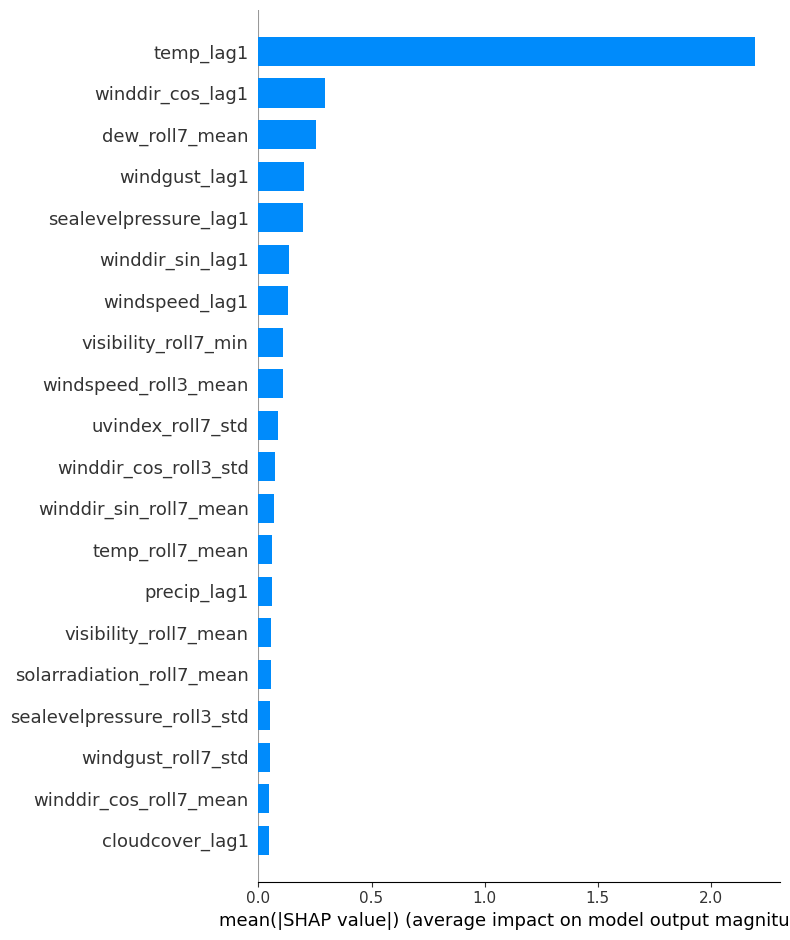

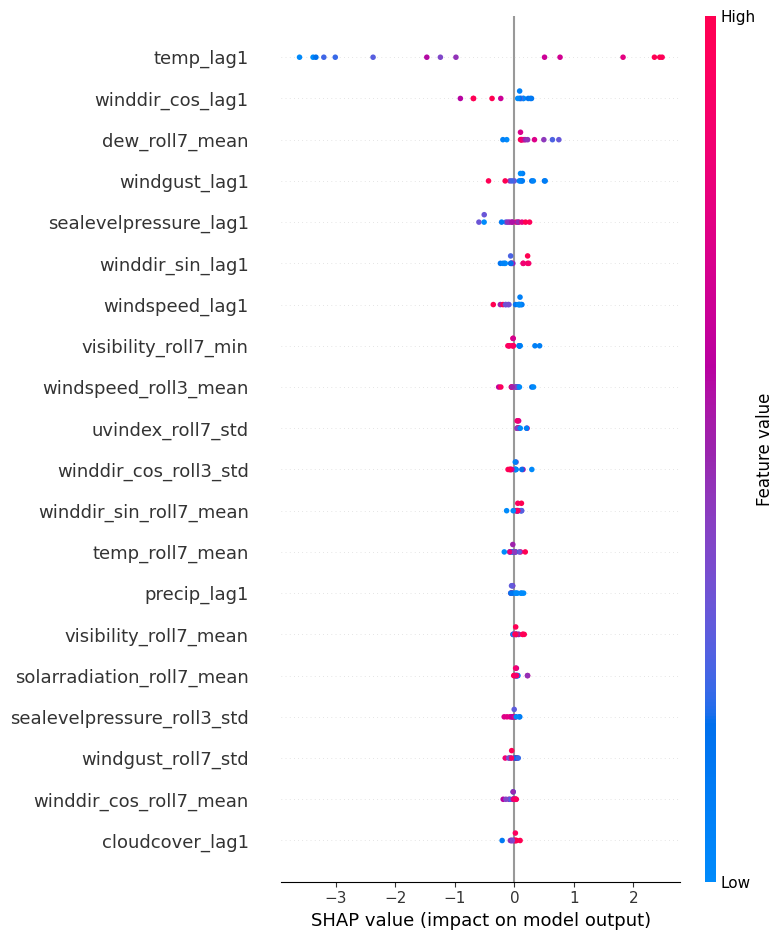

In [ ]:
explainer_rf = shap.TreeExplainer(final_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.show()
shap.summary_plot(shap_values_rf, X_test)
plt.show()
# Force Plot
shap.force_plot(explainer_rf.expected_value, shap_values_rf[sample_index, :], X_test.iloc[sample_index, :])
plt.show()

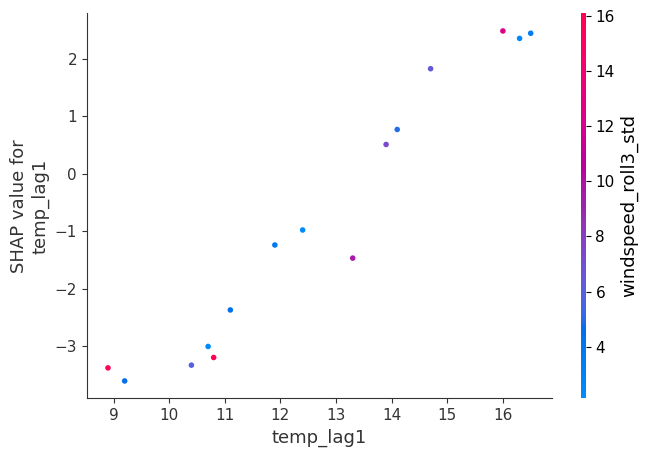

In [ ]:
# Dependence Plot
shap.dependence_plot("temp_lag1", shap_values_rf, X_test)
plt.show()

Best trial: FrozenTrial(number=56, state=1, values=[1.9360047747576061], datetime_start=datetime.datetime(2025, 3, 28, 18, 5, 51, 805109), datetime_complete=datetime.datetime(2025, 3, 28, 18, 5, 52, 65325), params={'num_leaves': 46, 'max_depth': 3, 'learning_rate': 0.08370030591884824, 'n_estimators': 200, 'min_child_samples': 9, 'subsample': 0.8458169272408332, 'colsample_bytree': 0.5222410078227263, 'reg_alpha': 0.05485991906336026, 'reg_lambda': 4.5443454171569675e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=100, log=False, low=10, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=50), 'min_child_samples': IntDistribution(high=50, log=False, low=5, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=1e-08, step=None)}, trial_id=56, value=None)
Best MSE: 1.9360047747576061
Best params: {'num_leaves': 46, 'max_depth': 3, 'learning_rate': 0.08370030591884824, 'n_estimators': 200, 'min_child_samples': 9, 'subsample': 0.8458169272408332, 'colsample_bytree': 0.5222410078227263, 'reg_alpha': 0.05485991906336026, 'reg_lambda': 4.5443454171569675e-05}
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 1.93601
MSE with early stopping: 1.9360047747576061
Root Mean Squared Error (best model): 1.3914038862809053

## Compare with Prophet

Compared to Prophet, both Random Forest and LightGBM with Optuna-tuned hyperparameters significantly improved forecasting accuracy. Prophet, with an RMSE of 2.69, struggled as it mainly captures seasonality and trends but lacks the ability to model complex feature interactions. Random Forest reduced the error to 1.46, leveraging its ensemble learning ability to handle non-linear relationships effectively. LightGBM outperformed both models, achieving the lowest RMSE of 1.39, benefiting from its boosting mechanism, efficient handling of high-dimensional data, and superior generalization. This demonstrates that while Prophet is useful for trend-based forecasting, optimized machine learning models offer far greater precision when multiple features contribute to the prediction.

# Task 7

In [ ]:
df1.columns

Index(['datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'uvindex', 'severerisk', 'moonphase',
       'Partly cloudy throughout the day', 'morning rain', 'afternoon rain',
       'clearing later', 'Cloudy skies throughout the day', 'chance of rain',
       'late afternoon rain', 'Becoming cloudy in the afternoon',
       'sun_duration', 'preciptype_dry', 'preciptype_rain', 'preciptype_snow',
       'station_cluster', 'temp_min', 'temp_max', 'temp_mean',
       'conditions_encoded', 'winddir_sin', 'winddir_cos'],
      dtype='object')

In [ ]:
numeric_cols = ['temp', 'dew', 'humidity', 'precip', 'precipprob',
'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed',
'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
'uvindex', 'severerisk', 'moonphase', 'sun_duration','winddir_sin',
'winddir_cos', 'temp_mean', 'temp_min', 'temp_max']

mode_cols = ['station_cluster', 'conditions_encoded']

### Function to Fill Mode

In [ ]:
def get_mode(series):
    mode_val = series.mode(dropna=True)
    if len(mode_val) == 0:
        return np.nan
    else:
        return mode_val.iloc[0]

### Function to fill "preciptype" based on the most frequently occurring "preciptype"

In [ ]:
def pick_dominant_preciptype(group):
    sum_dry = group['preciptype_dry'].sum()
    sum_rain = group['preciptype_rain'].sum()
    sum_snow = group['preciptype_snow'].sum()

    max_val = max(sum_dry, sum_rain, sum_snow)
    return pd.Series({
        'preciptype_dry': 1 if sum_dry == max_val else 0,
        'preciptype_rain': 1 if sum_rain == max_val else 0,
        'preciptype_snow': 1 if sum_snow == max_val else 0
    })

### Numerical columns are filled with the mean, while the "stations" and "conditions" columns are filled with the mode

In [ ]:
def aggregator(group):
    numeric_mean = group[numeric_cols].mean()

    station_mode = get_mode(group['station_cluster'])
    condition_mode = get_mode(group['conditions_encoded'])
    precip_info = pick_dominant_preciptype(group)

    result = numeric_mean.copy()
    result['station_cluster'] = station_mode
    result['conditions_encoded'] = condition_mode
    result = pd.concat([result, precip_info])
    return result


### Reset datetime as index to split data by week

In [ ]:
df1.set_index('datetime', inplace=True)

In [ ]:
df_weekly = df1.groupby(pd.Grouper(freq='W')).apply(aggregator)

In [ ]:
df_weekly.head()

,temp,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,moonphase,sun_duration,winddir_sin,winddir_cos,temp_mean,temp_min,temp_max,station_cluster,conditions_encoded,preciptype_dry,preciptype_rain,preciptype_snow
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-01,18.900000,13.700000,74.300000,0.144000,100.000000,4.170000,0.0,0.0,25.000000,11.300000,1023.700000,46.500000,18.600000,39.800000,3.000000,10.0,0.570000,11.681389,0.170209,-0.985408,13.761194,2.600000,26.200000,0.0,4.0,0.0,1.0,0.0
2023-10-08,16.900000,11.128571,70.814286,0.061000,71.428571,4.168571,0.0,0.0,24.785714,11.414286,1025.142857,52.357143,21.114286,48.628571,3.714286,10.0,0.698571,11.444603,-0.577554,-0.565332,14.322831,2.228571,26.771429,0.0,4.0,0.0,1.0,0.0
2023-10-15,17.285714,10.714286,67.514286,0.751286,71.428571,8.334286,0.0,0.0,38.742857,17.542857,1018.485714,76.200000,22.457143,35.171429,2.428571,10.0,0.640000,11.032500,-0.612571,-0.283022,13.930979,2.285714,25.971429,0.0,4.0,0.0,1.0,0.0
2023-10-22,13.328571,9.557143,78.628571,2.297429,71.428571,25.000000,0.0,0.0,49.557143,22.242857,1000.428571,88.128571,21.942857,26.542857,2.000000,10.0,0.162857,10.625873,0.098616,-0.591560,13.588578,2.542857,25.200000,0.0,3.0,0.0,1.0,0.0
2023-10-29,12.500000,10.400000,87.400000,6.515143,100.000000,31.548571,0.0,0.0,45.457143,19.914286,998.985714,91.128571,19.628571,20.185714,1.285714,10.0,0.415714,10.228690,-0.383144,-0.769159,13.076392,3.114286,24.657143,0.0,3.0,0.0,1.0,0.0


Except for the "station_cluster" column (known before the prediction date),
 all other columns must use lag and a 3-day rolling window to avoid data leakage.

In [ ]:
column_not_lag = ['station_cluster']
def create_lag_rolling_features(df_weekly, lag=1, window=3):

    numeric_cols = df_weekly.columns [~df_weekly.columns.isin(column_not_lag)]

    for col in numeric_cols:
        # Tạo lag features
        df_weekly[f'{col}_lag{lag}'] = df_weekly[col].shift(lag)

        # Tạo rolling features
        df_weekly[f'{col}_rolling_mean{window}'] = df_weekly[col].rolling(window=window, min_periods=1, closed='left').mean()
        df_weekly.drop(columns=[col], inplace=True) if col != 'temp' else None

    df_weekly.dropna(inplace=True)

    return df_weekly

weekly_df = create_lag_rolling_features(df_weekly, lag=1, window=3)
weekly_df

,temp,station_cluster,temp_lag1,temp_rolling_mean3,dew_lag1,dew_rolling_mean3,humidity_lag1,humidity_rolling_mean3,precip_lag1,precip_rolling_mean3,precipprob_lag1,precipprob_rolling_mean3,precipcover_lag1,precipcover_rolling_mean3,snow_lag1,snow_rolling_mean3,snowdepth_lag1,snowdepth_rolling_mean3,windgust_lag1,windgust_rolling_mean3,windspeed_lag1,windspeed_rolling_mean3,sealevelpressure_lag1,sealevelpressure_rolling_mean3,cloudcover_lag1,cloudcover_rolling_mean3,visibility_lag1,visibility_rolling_mean3,solarradiation_lag1,solarradiation_rolling_mean3,uvindex_lag1,uvindex_rolling_mean3,severerisk_lag1,severerisk_rolling_mean3,moonphase_lag1,moonphase_rolling_mean3,sun_duration_lag1,sun_duration_rolling_mean3,winddir_sin_lag1,winddir_sin_rolling_mean3,winddir_cos_lag1,winddir_cos_rolling_mean3,temp_mean_lag1,temp_mean_rolling_mean3,temp_min_lag1,temp_min_rolling_mean3,temp_max_lag1,temp_max_rolling_mean3,conditions_encoded_lag1,conditions_encoded_rolling_mean3,preciptype_dry_lag1,preciptype_dry_rolling_mean3,preciptype_rain_lag1,preciptype_rain_rolling_mean3,preciptype_snow_lag1,preciptype_snow_rolling_mean3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-08,16.900000,0.0,18.900000,18.900000,13.700000,13.700000,74.300000,74.300000,0.144000,0.144000,100.000000,100.000000,4.170000,4.170000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,11.300000,11.300000,1023.700000,1023.700000,46.500000,46.500000,18.600000,18.600000,39.800000,39.800000,3.000000,3.000000,10.000000,10.000000,0.570000,0.570000,11.681389,11.681389,0.170209,0.170209,-0.985408,-0.985408,13.761194,13.761194,2.600000,2.600000,26.200000,26.200000,4.0,4.000000,0.0,0.000000,1.0,1.000000,0.0,0.000000
2023-10-15,17.285714,0.0,16.900000,17.900000,11.128571,12.414286,70.814286,72.557143,0.061000,0.102500,71.428571,85.714286,4.168571,4.169286,0.000000,0.000000,0.000000,0.000000,24.785714,24.892857,11.414286,11.357143,1025.142857,1024.421429,52.357143,49.428571,21.114286,19.857143,48.628571,44.214286,3.714286,3.357143,10.000000,10.000000,0.698571,0.634286,11.444603,11.562996,-0.577554,-0.203672,-0.565332,-0.775370,14.322831,14.042012,2.228571,2.414286,26.771429,26.485714,4.0,4.000000,0.0,0.000000,1.0,1.000000,0.0,0.000000
2023-10-22,13.328571,0.0,17.285714,17.695238,10.714286,11.847619,67.514286,70.876190,0.751286,0.318762,71.428571,80.952381,8.334286,5.557619,0.000000,0.000000,0.000000,0.000000,38.742857,29.509524,17.542857,13.419048,1018.485714,1022.442857,76.200000,58.352381,22.457143,20.723810,35.171429,41.200000,2.428571,3.047619,10.000000,10.000000,0.640000,0.636190,11.032500,11.386164,-0.612571,-0.339972,-0.283022,-0.611254,13.930979,14.005001,2.285714,2.371429,25.971429,26.314286,4.0,4.000000,0.0,0.000000,1.0,1.000000,0.0,0.000000
2023-10-29,12.500000,0.0,13.328571,15.838095,9.557143,10.466667,78.628571,72.319048,2.297429,1.036571,71.428571,71.428571,25.000000,12.500952,0.000000,0.000000,0.000000,0.000000,49.557143,37.695238,22.242857,17.066667,1000.428571,1014.685714,88.128571,72.228571,21.942857,21.838095,26.542857,36.780952,2.000000,2.714286,10.000000,10.000000,0.162857,0.500476,10.625873,11.034325,0.098616,-0.363836,-0.591560,-0.479971,13.588578,13.947463,2.542857,2.352381,25.200000,25.980952,3.0,3.666667,0.0,0.000000,1.0,1.000000,0.0,0.000000
2023-11-05,11.042857,0.0,12.500000,14.371429,10.400000,10.223810,87.400000,77.847619,6.515143,3.187952,100.000000,80.952381,31.548571,21.627619,0.000000,0.000000,0.000000,0.000000,45.457143,44.585714,19.914286,19.900000,998.985714,1005.966667,91.128571,85.152381,19.628571,21.342857,20.185714,27.300000,1.285714,1.904762,10.000000,10.000000,0.415714,0.406190,10.228690,10.629021,-0.383144,-0.299033,-0.769159,-0.547914,13.076392,13.531983,3.114286,2.647619,24.657143,25.276190,3.0,3.333333,0.0,0.000000,1.0,1.000000,0.0,0.000000
2023-11-12,9.371429,0.0,11.042857,12.290476,8.385714,9.447619,84.385714,83.471429,3.699286,4.170619,100.000000,90.476190,27.380000,27.976190,0.000000,0.000000,0.000000,0.0

## Chia train test bằng 2 tuần cuối

In [ ]:
X = weekly_df.drop(columns=['temp'])
y = weekly_df['temp']

X_train, X_test = X.iloc[:-2], X.iloc[-2:]
y_train, y_test = y.iloc[:-2], y.iloc[-2:]

Vì dữ liệu ít nên có một số thay đổi:
- Giảm các parameter để tránh overfit và mất thời gian khi chạy.
- Thay vì chi train-val 80/20 thì dùng cross validation

In [ ]:
def train_lgbm(X_train, y_train, X_test, y_test, n_splits=5, random_state=42):
    def objective(trial):
        # Adjusted parameter ranges for smaller data
        params = {
            "objective": "regression", "metric": "rmse", "random_state": random_state,
            "verbosity": -1,
            "n_estimators": trial.suggest_int("n_estimators", 50, 400),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 4, 25),
            "max_depth": trial.suggest_int("max_depth", 2, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 3, 20),
            "subsample": trial.suggest_float("subsample", 0.4, 0.9),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        }

        # K-Fold Cross-Validation
        if len(X_train) < n_splits:
            print(f"Warning: Skipping K-Fold due to insufficient samples ({len(X_train)}).")
            return float('inf')

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        rmse_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                callbacks=[lgb.early_stopping(15, verbose=False)],
            )
            preds = model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, preds))

            # Rudimentary check, otherwise the mean calculation might fail later
            if np.isnan(rmse) or np.isinf(rmse):
                 print(f"Warning: Invalid RMSE encountered in fold {fold}. Returning high error for trial.")
                 return float('inf') # Signal a bad trial if any fold produces invalid RMSE

            rmse_scores.append(rmse)

        return np.mean(rmse_scores) # Return average RMSE across folds

    # --- Run Optuna Study ---
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    # --- Get Best Params & Train Final Model ---
    best_params = study.best_params
    best_params.update({
        "objective": "regression", "metric": "rmse",
        "random_state": random_state, "verbosity": -1
    })

    print(f"Best Parameters: {best_params}")

    # Train final model on the entire training set
    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # --- Evaluate on Test Set ---
    predictions = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    test_mse = mean_squared_error(y_test, predictions)

    print(f"Test RMSE: {test_rmse}")
    print(f"Test MSE: {test_mse}")

    return final_model, test_rmse, test_mse

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test, n_splits=5, random_state=42):

    def objective(trial):
        # Adjusted parameter ranges for smaller data & Random Forest specifics
        params = {
            # Fewer estimators needed for small data
            "n_estimators": trial.suggest_int("n_estimators", 50, 400),
            # Limit depth significantly to prevent overfitting
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            # Increase min samples for split/leaf to regularize
            "min_samples_split": trial.suggest_int("min_samples_split", 3, 25),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 15),
            # Keep feature sampling options
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "random_state": random_state,
            "n_jobs": -1 # Use all available cores
        }

        # K-Fold Cross-Validation
        if len(X_train) < n_splits:
            print(f"Warning: Skipping K-Fold due to insufficient samples ({len(X_train)}).")
            return float('inf') # Signal bad trial

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        rmse_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = RandomForestRegressor(**params)
            model.fit(X_train_fold, y_train_fold)
            preds = model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, preds))

            if np.isnan(rmse) or np.isinf(rmse):
                 print(f"Warning: Invalid RMSE encountered in fold {fold}. Returning high error for trial.")
                 return float('inf') # Signal bad trial

            rmse_scores.append(rmse)

        return np.mean(rmse_scores) # Return average RMSE

    # --- Run Optuna Study ---
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    # --- Get Best Params & Train Final Model ---
    best_params = study.best_params
    best_params["random_state"] = random_state # Ensure reproducibility
    best_params["n_jobs"] = -1 # Ensure final model uses cores

    print(f"Best Parameters: {best_params}")

    final_model = RandomForestRegressor(**best_params)
    final_model.fit(X_train, y_train) # Train on all training df

    # --- Evaluate on Test Set ---
    predictions = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    test_r2 = r2_score(y_test, predictions)
    test_mse = mean_squared_error(y_test, predictions)

    print(f"Test RMSE: {test_rmse}")
    print(f"Test R-squared: {test_r2}")
    print(f"Test MSE: {test_mse}")

    return final_model, test_rmse, test_r2, test_mse

In [ ]:
lightgbm_model, lgb_rmse, lgb_mse = train_lgbm(X_train, y_train, X_test, y_test)

[I 2025-03-30 15:06:59,226] A new study created in memory with name: no-name-4ed827cc-748f-4aba-80f4-8cfcf71d5263
[I 2025-03-30 15:06:59,334] Trial 0 finished with value: 2.8127216277480613 and parameters: {'n_estimators': 157, 'learning_rate': 0.10520254632428173, 'num_leaves': 22, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.45297210216803135, 'colsample_bytree': 0.6613086075922747, 'reg_alpha': 9.87059677915111, 'reg_lambda': 0.023557831459805518}. Best is trial 0 with value: 2.8127216277480613.
[I 2025-03-30 15:06:59,474] Trial 1 finished with value: 3.940966558385277 and parameters: {'n_estimators': 188, 'learning_rate': 0.0033833004349836573, 'num_leaves': 16, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.6606935904386809, 'colsample_bytree': 0.6492294982619412, 'reg_alpha': 0.12635224049399724, 'reg_lambda': 0.011488728784223896}. Best is trial 0 with value: 2.8127216277480613.
[I 2025-03-30 15:06:59,575] Trial 2 finished with value: 2.871996005562738 and pa

Best Parameters: {'n_estimators': 332, 'learning_rate': 0.03761091249285411, 'num_leaves': 19, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.6677377099457776, 'colsample_bytree': 0.7352761107635825, 'reg_alpha': 0.5468840260878925, 'reg_lambda': 0.07311872225609349, 'objective': 'regression', 'metric': 'rmse', 'random_state': 42, 'verbosity': -1}
Test RMSE: 2.393435495567632
Test MSE: 5.728533471443077


In [ ]:
rf_model, rmse_rf, r2_rf, mse_rf= train_random_forest(X_train, y_train, X_test, y_test)

[I 2025-03-30 15:07:19,227] A new study created in memory with name: no-name-27516396-e422-4c4b-b4ba-2b7bee697ed7
[I 2025-03-30 15:07:22,538] Trial 0 finished with value: 3.286413439630702 and parameters: {'n_estimators': 366, 'max_depth': 5, 'min_samples_split': 23, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 3.286413439630702.
[I 2025-03-30 15:07:25,484] Trial 1 finished with value: 3.0333835770469517 and parameters: {'n_estimators': 321, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 3.0333835770469517.
[I 2025-03-30 15:07:26,228] Trial 2 finished with value: 3.284808842024725 and parameters: {'n_estimators': 76, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 1 with value: 3.0333835770469517.
[I 2025-03-30 15:07:28,566] Trial 3 finished with value: 2.9607509812276325 and parameters: {'n_estimators': 260, 'max_depth': 8, 'min_sample

Best Parameters: {'n_estimators': 326, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'random_state': 42, 'n_jobs': -1}
Test RMSE: 1.3991818731894101
Test R-squared: 0.22839561785815565
Test MSE: 1.9577099142618268


## Feature importance weely df

### LGBM
- "temp_lag1" remains the most important feature, but it is no longer significantly dominant as in the daily dataframe.  
- "winddir_cos_lag1", "humidity_rolling_mean3", "uvindex_rolling_mean3", and "windgust_rolling_mean3" also play important roles in the model.

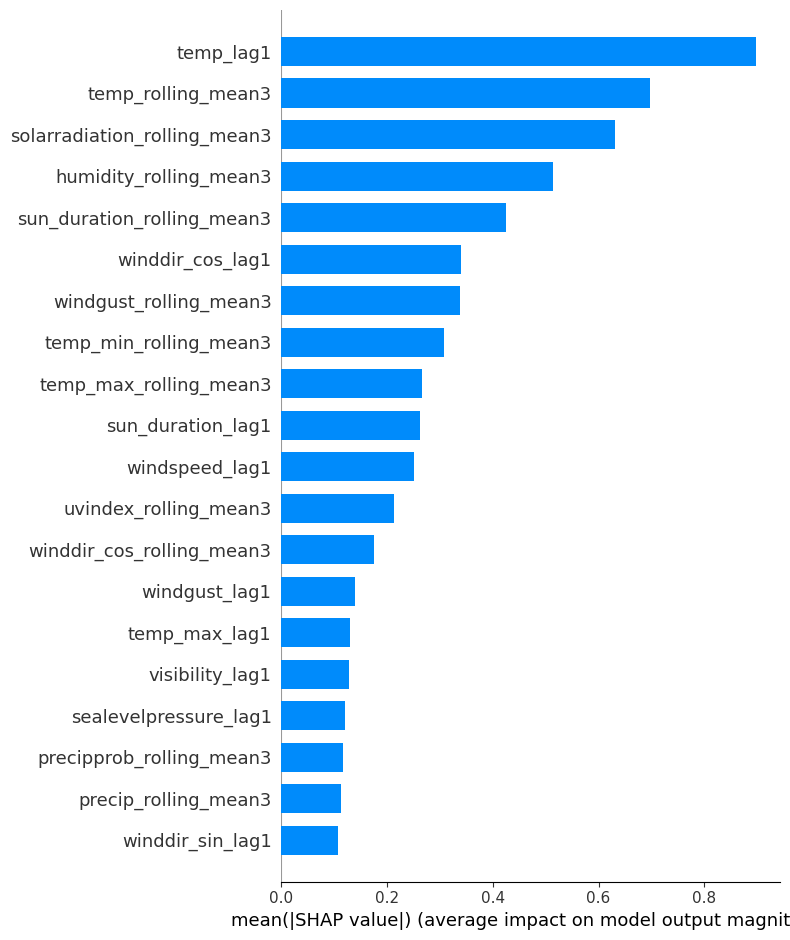

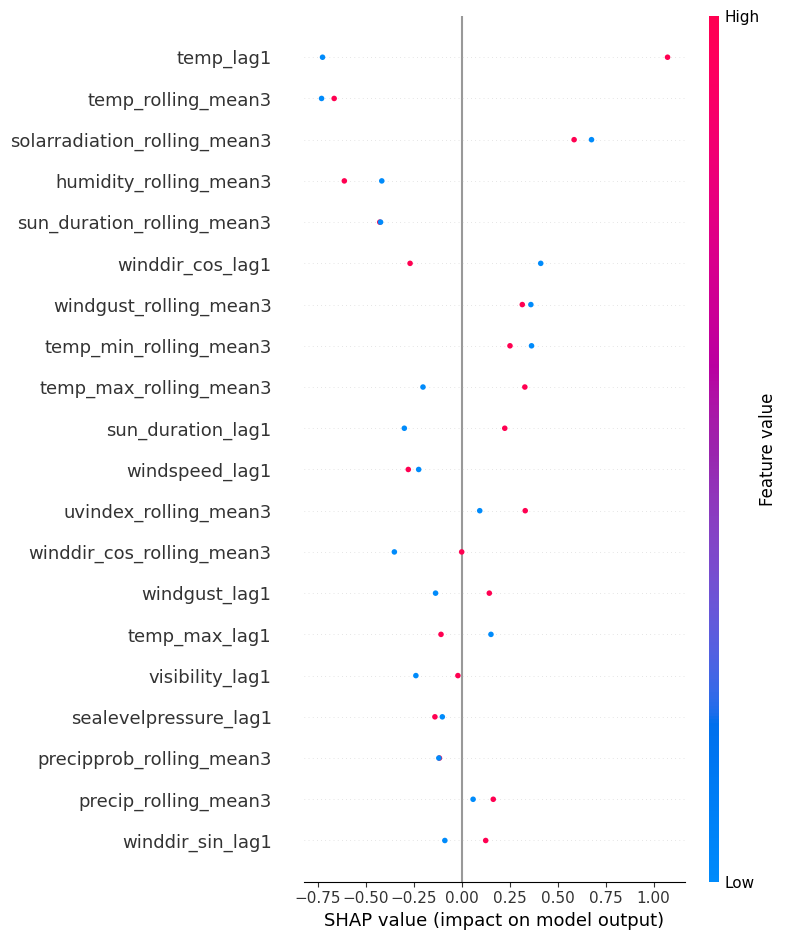

In [ ]:
explainer_lgb = shap.TreeExplainer(lightgbm_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Summary Plot (toàn bộ tập test)
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar")  # Mức độ quan trọng tổng thể
plt.show()
shap.summary_plot(shap_values_lgb, X_test)  # Dạng beeswarm (chi tiết hơn)
plt.show()
# Force Plot (cho một mẫu dữ liệu cụ thể)
sample_index = 0  # Chọn một mẫu bất kỳ từ tập test (ví dụ: mẫu đầu tiên)
shap.force_plot(explainer_lgb.expected_value, shap_values_lgb[sample_index, :], X_test.iloc[sample_index, :])
plt.show()

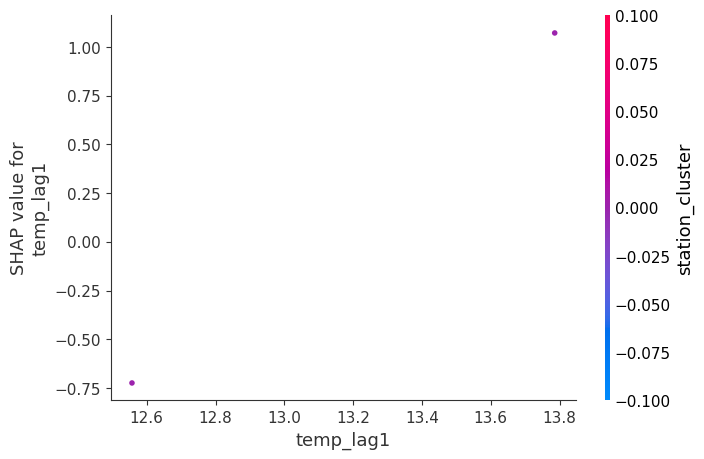

In [ ]:
# Dependence Plot (mối quan hệ giữa một feature và SHAP value của nó)
shap.dependence_plot("temp_lag1", shap_values_lgb, X_test)
plt.show()

### RF
- "humidity_rolling_mean3" is the most important: This is the biggest difference compared to LGBM.  
- "temp_lag1" ranks second: The temperature from the previous week remains important but is only the second most significant feature in the RF model.

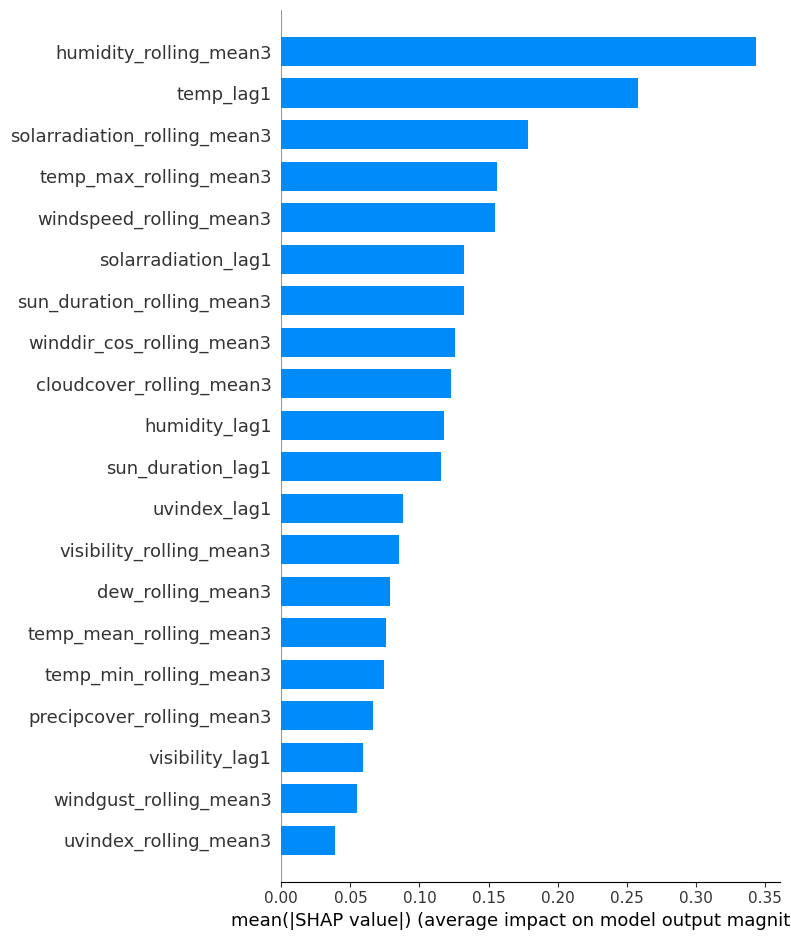

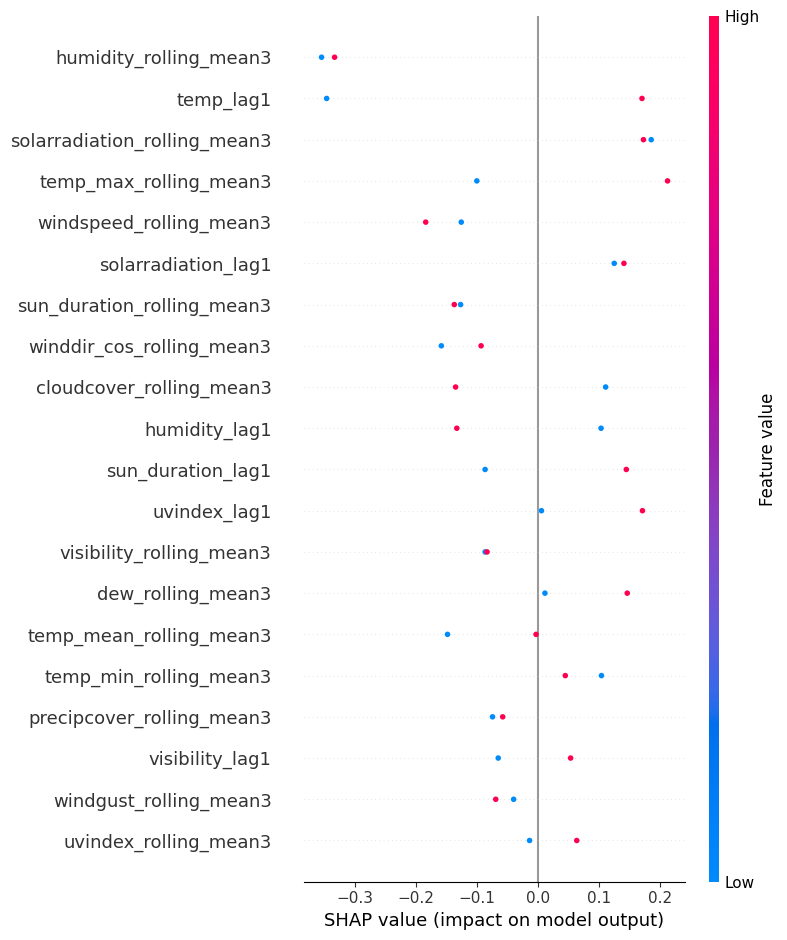

In [ ]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.show()
shap.summary_plot(shap_values_rf, X_test)
plt.show()
# Force Plot
shap.force_plot(explainer_rf.expected_value, shap_values_rf[sample_index, :], X_test.iloc[sample_index, :])
plt.show()

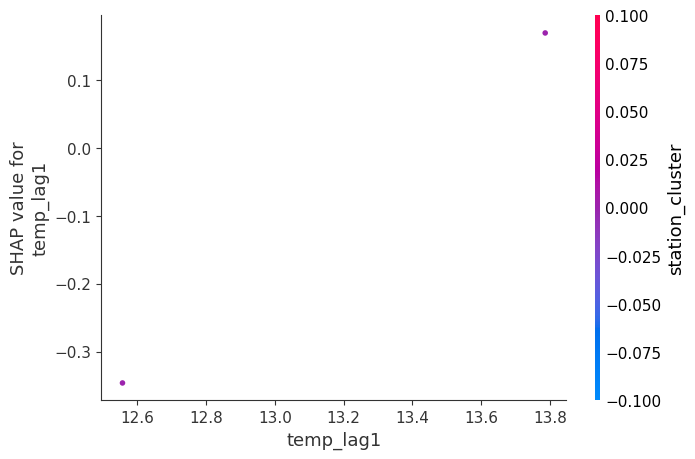

In [ ]:
# Dependence Plot
shap.dependence_plot("temp_lag1", shap_values_rf, X_test)
plt.show()